In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import tensorflow as tf

In [0]:
# 0. 데이터 분포 확인
boston = load_boston()
boston_df = pd.DataFrame(boston['data'],
                         columns=boston['feature_names'])
boston_df['house_price'] = boston['target']
boston_df.head(10)
boston_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,house_price
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [0]:
# 1. dataset nomalize수행 
data = (boston_df - boston_df.min(axis=0)) / (boston_df.max(axis=0) - boston_df.min(axis=0))
data = data.values
xs = data[:,:-1]
label = data[:,-1]


In [0]:
class Layer:
    def forward(self, x):
        """
        해당 Operation의 순전파를 계산
        """
        raise NotImplementedError
        
    def backward(self, grad):
        """
        해당 Operation의 역전파를 계산
        """
        raise NotImplementedError
        
    def update(self, learning_rate):
        """
        [optional]
        해당 Layer에 Weight가 있다면,
        w_old = w_new - learning_rate * dw
        """
        pass

class logit_layer(Layer) :
    def __init__(self, w_size, b_size):
        self.w = np.random.normal(loc= 0.0, scale=2/w_size[1], size = w_size)
        self.b = np.zeros(shape = b_size)
        self.b = np.reshape(self.b, (1,-1))
        #print("w_shape : ", self.w.shape)
         
    def forward(self, x) :
        self.x = x
        z = np.matmul(self.x, self.w) 
        z = z + self.b #dataframe에서 matmul axis issue, np.dot은 없음
        return z
    
    def backward(self, grad) :
        # dz/dw **
        self.del_w = np.matmul(grad.T, self.x) #미리 식 세워놓음(=? Dynamic programing )    
        # (2, d)*(d, 3)
        self.del_b = np.mean(grad, axis =0) 
        # dz/dx **
        self.del_a = np.matmul(grad, self.w.T)
        return self.del_a
        
    def update(self, learning_rate) :
        #print("w.shape : {}, del_w.shape : {}".format(self.w.shape, self.del_w.shape))
        self.w = self.w - (learning_rate * self.del_w.T)
        self.b = self.b - (learning_rate * self.del_b)
        pass
        
class relu_layer(Layer) :     
    def forward(self, z) :
        self.z = z
        return np.maximum(self.z, 0)
    
    def backward(self,grad) :
        return grad * np.where(self.z > 0  , 1, 0)
    
class mse_with_loss(Layer) :
    def __init__(self, p) : 
        self.p = np.reshape(np.array(p), (-1,1)) 

    def forward(self, z): #z는 계산된값
        self.z = z
        self.loss = np.mean((self.z - self.p)**2, axis =0)
        return self.loss

    def backward(self, grad) : #dL/dz = (y_h - y)
        #sig with CEE의 loss 계산 == MSE loss **
        self.del_loss = (self.z - self.p)
        self.del_loss = self.del_loss #**
        return self.del_loss

    
    

In [0]:
logit1 = logit_layer([13,50], 50)
relu1 = relu_layer()
logit2 = logit_layer([50,50], 50)
relu2 = relu_layer()
logit3 = logit_layer([50,1],1)
mse_with_loss_ = mse_with_loss(label)
loss_list = []

for epoch in range(300000) :
    z1 = logit1.forward(xs)
    acti1 = relu1.forward(z1)
    z2 = logit2.forward(acti1)
    acti2 = relu2.forward(z2)
    pred = logit3.forward(acti2)
    loss_ = mse_with_loss_.forward(pred)
    loss_list.append(loss_)
    if epoch % 500 == 0 :
        print("epoch : {}".format(epoch))
        print("loss : {}".format(loss_))
        rmse = np.sqrt(np.mean((pred - mse_with_loss_.p)**2, axis = 0))
        print("rmse : {}".format(rmse))
        print("========================")
    
    del_loss = mse_with_loss_.backward(1)
    del_logit3 = logit3.backward(del_loss)
    del_acti2 = relu2.backward(del_logit3)
    del_logit2 = logit2.backward(del_acti2)
    del_acti1 = relu1.backward(del_logit2)
    del_logit1 = logit1.backward(del_acti1)
    
    logit1.update(0.00001)
    logit2.update(0.00001)
    logit3.update(0.00001)



epoch : 0
loss : [0.3780908]
rmse : [0.61489089]
epoch : 500
loss : [0.01578817]
rmse : [0.125651]
epoch : 1000
loss : [0.01169686]
rmse : [0.108152]
epoch : 1500
loss : [0.01030045]
rmse : [0.10149114]
epoch : 2000
loss : [0.00969464]
rmse : [0.09846134]
epoch : 2500
loss : [0.00924115]
rmse : [0.09613089]
epoch : 3000
loss : [0.00891975]
rmse : [0.09444443]
epoch : 3500
loss : [0.00865737]
rmse : [0.09304497]
epoch : 4000
loss : [0.00841369]
rmse : [0.09172615]
epoch : 4500
loss : [0.00817633]
rmse : [0.09042307]
epoch : 5000
loss : [0.00793761]
rmse : [0.08909324]
epoch : 5500
loss : [0.00770174]
rmse : [0.08775957]
epoch : 6000
loss : [0.00746865]
rmse : [0.08642138]
epoch : 6500
loss : [0.00722566]
rmse : [0.08500387]
epoch : 7000
loss : [0.00700721]
rmse : [0.08370906]
epoch : 7500
loss : [0.00677198]
rmse : [0.08229204]
epoch : 8000
loss : [0.00655212]
rmse : [0.08094519]
epoch : 8500
loss : [0.00636359]
rmse : [0.07977209]
epoch : 9000
loss : [0.00620299]
rmse : [0.07875904]
ep

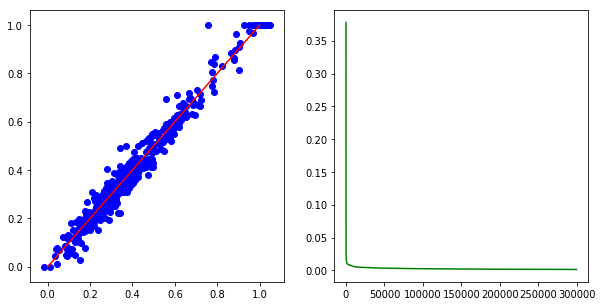

In [0]:
pred_ = np.reshape(pred, (-1,))
label_ = np.reshape(label, (-1)) 

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(pred_, label_, color='b')
ax1.plot([0,1], [0,1], color='r')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(loss_list, color='g')